In [1]:
import torch
from torchvision import datasets, transforms, models
import torchvision.models as models

from torch.nn.utils import parameters_to_vector as p2v

import numpy as np
import json, time

In [2]:
data_dir = "dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# plot the image
def show_image_prev(image_numpy_arr):
    fig, ax = plt.subplots()

    image = image_numpy_arr.transpose(1, 2, 0)
    print(image.shape)
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])
torch.Size([8])
(224, 224, 3)


<Axes: >

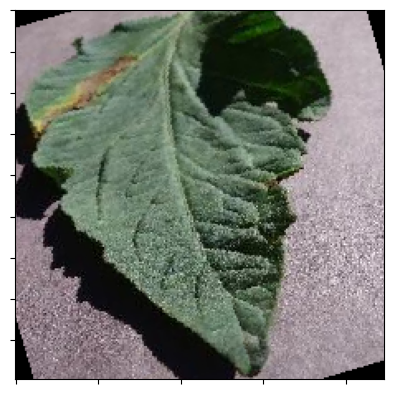

In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(30), #data augumnetation
                                       #transforms.RandomResizedCrop(IMAGE_SIZE),#resize
                                       transforms.CenterCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(), #data augumnetation
                                       transforms.ToTensor(),
                                       #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

val_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(IMAGE_SIZE), #resize
                                     transforms.ToTensor(),
                                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

dataiter = iter(train_loader)
images, classes = next(dataiter)
print(type(images))
print(images.shape)
print(classes.shape)

show_image_prev(np.array(images[0]))

In [5]:
train_data.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [10]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

model = models.resnet34()

In [11]:
#model.fc = nn.Linear(2048, len(train_data.class_to_idx)) #for resnet 50
model.fc = nn.Linear(512, len(train_data.class_to_idx)) # for resnet 18

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model.load_state_dict(torch.load("resnet34.torch", weights_only=True))

<All keys matched successfully>

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [14]:
valid_accuracy_track = []

In [15]:
epochs = 25 # run more iterations

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for images, classes in train_loader:
        # To device - to transfrom the image and classes to CPU|GPU
        images, classes = images.to(device), classes.to(device)
        
        # clears old gradients from the last step
        optimizer.zero_grad()

        # train the images
        outputs = model(images)

        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, classes)

        # compute the loss of every parameter
        loss.backward()

        # apply the optimizer and its parameters
        optimizer.step()

        #update the loss
        running_loss += loss.item()

    else: # doesnt run if i break out of loop
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for images, classes in val_loader:          
                # Use GPU
                images, classes = images.to(device), classes.to(device)
                
                # validate the images
                outputs = model(images)

                # compute validation loss
                loss = criterion(outputs, classes)

                #update loss
                validation_loss += loss.item()

                # get the exponential of the outputs
                ps = torch.exp(outputs)

                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)

                # reshape the tensor
                equals = top_class == classes.view(*top_class.shape)
                #print(type(equals), equals)

                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # change the mode to train for the next epochs

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader))
             )
        valid_accuracy_track.append((accuracy/len(val_loader)).item())

end_time = time.time()
elapsed = end_time - start_time

Epoch: 1/25..  Training Loss: 1.210..  Valid Loss: 0.956..  Valid Accuracy: 0.782
Epoch: 2/25..  Training Loss: 0.665..  Valid Loss: 1.708..  Valid Accuracy: 0.730
Epoch: 3/25..  Training Loss: 0.487..  Valid Loss: 0.971..  Valid Accuracy: 0.853
Epoch: 4/25..  Training Loss: 0.377..  Valid Loss: 0.831..  Valid Accuracy: 0.917
Epoch: 5/25..  Training Loss: 0.295..  Valid Loss: 0.701..  Valid Accuracy: 0.907
Epoch: 6/25..  Training Loss: 0.247..  Valid Loss: 0.603..  Valid Accuracy: 0.915
Epoch: 7/25..  Training Loss: 0.198..  Valid Loss: 1.426..  Valid Accuracy: 0.852
Epoch: 8/25..  Training Loss: 0.184..  Valid Loss: 0.423..  Valid Accuracy: 0.938
Epoch: 9/25..  Training Loss: 0.157..  Valid Loss: 0.674..  Valid Accuracy: 0.931
Epoch: 10/25..  Training Loss: 0.143..  Valid Loss: 0.385..  Valid Accuracy: 0.918
Epoch: 11/25..  Training Loss: 0.125..  Valid Loss: 0.519..  Valid Accuracy: 0.939
Epoch: 12/25..  Training Loss: 0.108..  Valid Loss: 0.295..  Valid Accuracy: 0.951
Epoch: 13/25.

In [16]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["valid_accuracy"]["resnet34"] = valid_accuracy_track
stats["time_taken"]["resnet34"] = elapsed
stats["params"]["resnet34"] = p2v(model.parameters()).numel()

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

In [17]:
torch.save(model.state_dict(), "resnet34.torch")

In [18]:
model.class_to_idx = train_data.class_to_idx
model.class_to_idx.items()

dict_items([('Tomato___Bacterial_spot', 0), ('Tomato___Early_blight', 1), ('Tomato___Late_blight', 2), ('Tomato___Leaf_Mold', 3), ('Tomato___Septoria_leaf_spot', 4), ('Tomato___Spider_mites Two-spotted_spider_mite', 5), ('Tomato___Target_Spot', 6), ('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 7), ('Tomato___Tomato_mosaic_virus', 8), ('Tomato___healthy', 9)])

In [19]:
def plot_solution(image_path, ps, classes):
    plt.figure(figsize = (6,10))
    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2]);
    plt.show()

# plot the image
def show_image(image_numpy_arr):
    fig, ax = plt.subplots()

    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image_numpy_arr.transpose(1, 2, 0)

    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def process_image(image_path, show):
    test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.RandomRotation(30), transforms.CenterCrop(IMAGE_SIZE), transforms.ToTensor()])
    im = Image.open(image_path)
    im = test_transform(im)
    if show: show_image(np.array(im))
    return im

In [20]:
def predict(image, model, show=True):
    with torch.no_grad():
        model.eval()
        image = process_image(image, show)
        image_inp = image.unsqueeze(0)
        
        image_inp = image_inp.to(device)
        
        outputs = model(image_inp)
    
    #print("debug: ", )
    #ps = torch.exp(outputs)
    ps = torch.nn.functional.softmax(outputs, dim=1)

    top_p, top_cls = ps.topk(5, dim=1)
    top_cls = top_cls.cpu().numpy().tolist()[0]

    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    return top_p, top_cls

In [21]:
def predict_file(image, model):
    ps, classes = predict(image, model)
    ps = ps.cpu().detach().numpy().tolist()[0]
    print(ps)
    print(classes)
    plot_solution(image, ps, classes)

[0.7663082480430603, 0.2319062352180481, 0.0010358296567574143, 0.0004488364211283624, 0.0002115265524480492]
['Tomato___healthy', 'Tomato___Target_Spot', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_mosaic_virus']


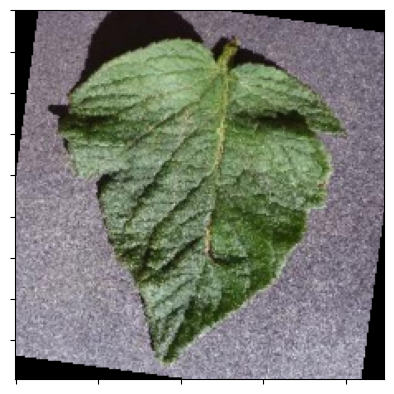

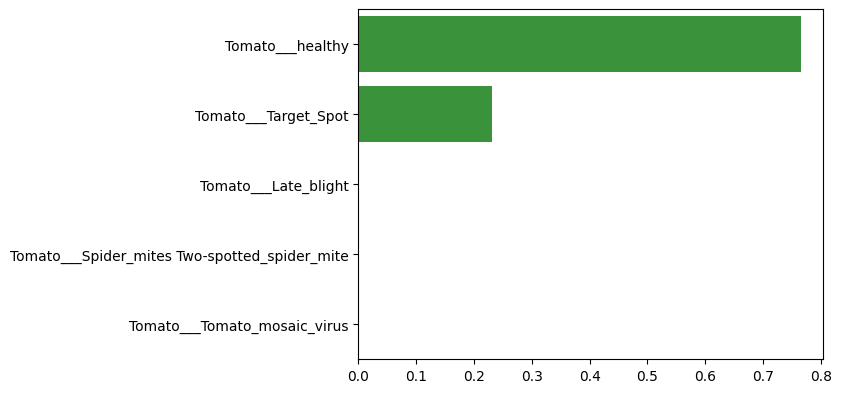

In [23]:
folder = 'Tomato___healthy'
file = '3eaf72d6-be20-4929-b6dc-58f6c9edf2bd___RS_HL 0031_flipTB.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9646813869476318, 0.025895191356539726, 0.006805334705859423, 0.0015100317541509867, 0.0005531501956284046]
['Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy', 'Tomato___Tomato_mosaic_virus']


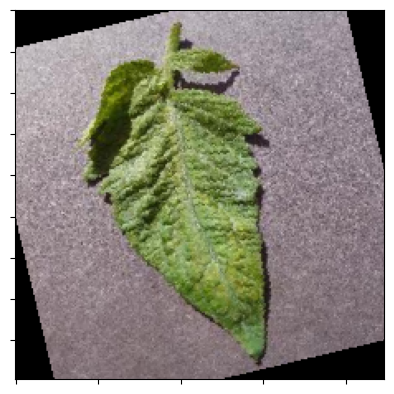

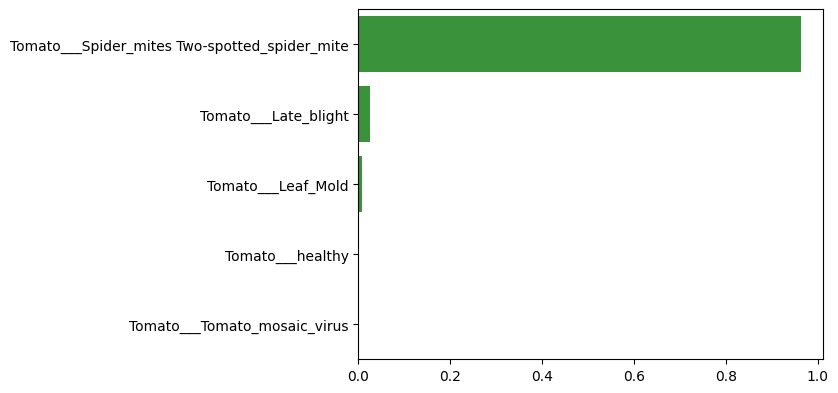

In [24]:
folder = 'Tomato___Spider_mites Two-spotted_spider_mite'
file = '3cf4bee8-cd23-461c-b1c4-1d857b37ad76___Com.G_SpM_FL 1223_180deg.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9997363686561584, 0.00026239658473059535, 5.31354032773379e-07, 5.000199507776415e-07, 1.2039947705488885e-07]
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight', 'Tomato___Bacterial_spot']


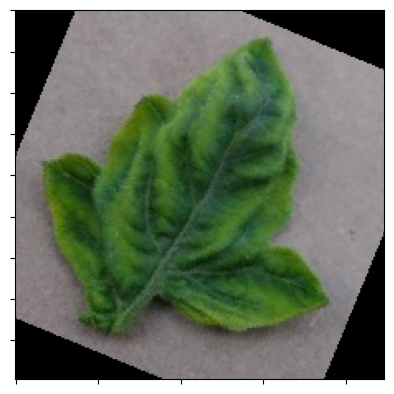

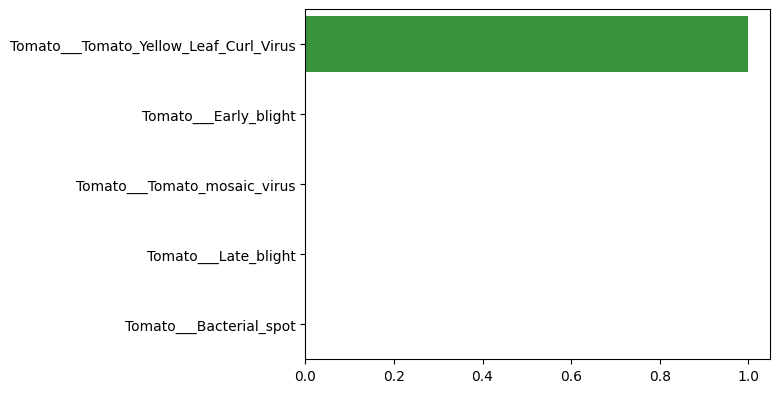

In [25]:
folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = '599329fe-867f-402a-8d37-a0c351fc2d03___YLCV_GCREC 2822.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9999585151672363, 3.370918057044037e-05, 6.121090336819179e-06, 1.0431920145492768e-06, 5.628908184007742e-07]
['Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Late_blight']


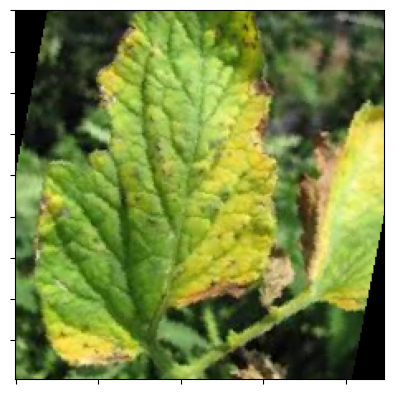

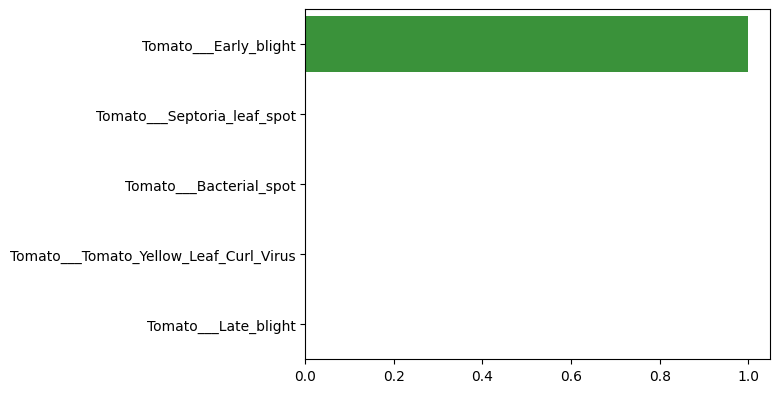

In [27]:
# test

file = 'image_bacterial_spot.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

[0.9921048879623413, 0.007763517554849386, 7.558007928309962e-05, 2.9774073482258245e-05, 2.0395074898260646e-05]
['Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot']


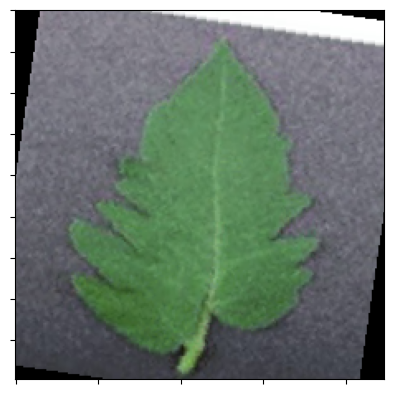

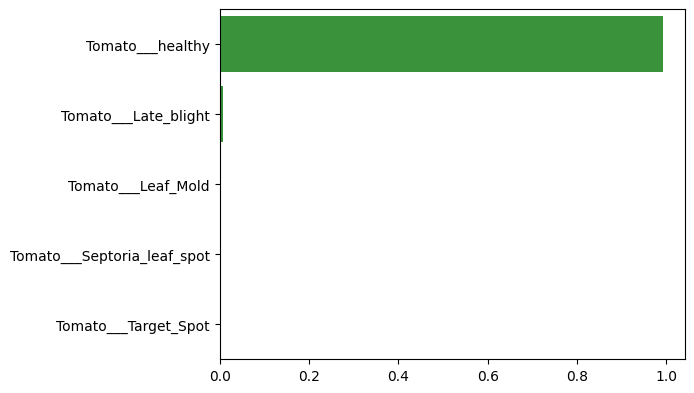

In [28]:
# test

file = 'image_healthy.jpg'
image = f"{data_dir}/test/{file}"
predict_file(image, model)

[0.9997263550758362, 0.0002665746142156422, 6.9515963332378305e-06, 1.2234477253514342e-07, 4.3063941745913326e-08]
['Tomato___Late_blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold']


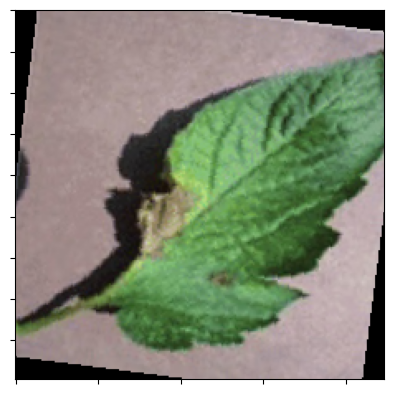

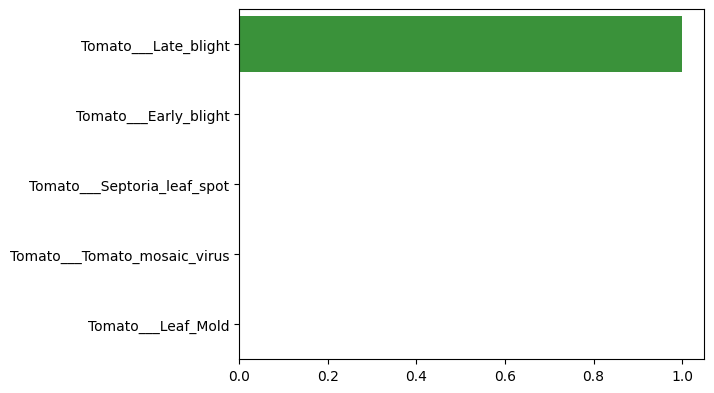

In [29]:
# test

#folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = 'image_late_blight.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

In [30]:
import os

accuracy = total = 0

true_list = []
pred = []

for (root, dirs, files) in os.walk(data_dir + "\\val"):
    if len(files) == 0:
        continue

    folder = root.split("\\")[-1]

    fol_acc = fol_tot = 0
    
    for file in files:
        image = f"{data_dir}/val/{folder}/{file}"
        ps, classes = predict(image, model, False)
        if classes[0] == folder:
            accuracy += 1
            fol_acc += 1

        true_list.append(folder)
        pred.append(classes[0])
        total += 1
        fol_tot += 1

    print(f"{folder}: {fol_acc}/{fol_tot} OR {fol_acc/fol_tot :.2f}")

print("\n")
print(f"FINAL: {accuracy}/{total} OR {accuracy/total :.2f}")

Tomato___Bacterial_spot: 394/425 OR 0.93
Tomato___Early_blight: 477/480 OR 0.99
Tomato___healthy: 388/481 OR 0.81
Tomato___Late_blight: 441/463 OR 0.95
Tomato___Leaf_Mold: 469/470 OR 1.00
Tomato___Septoria_leaf_spot: 411/436 OR 0.94
Tomato___Spider_mites Two-spotted_spider_mite: 410/435 OR 0.94
Tomato___Target_Spot: 396/457 OR 0.87
Tomato___Tomato_mosaic_virus: 375/448 OR 0.84
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 481/490 OR 0.98


FINAL: 4242/4585 OR 0.93


In [31]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["final_accuracy"]["resnet34"] = accuracy/total

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

[Text(0.5, 23.38159722222222, 'Pred'), Text(77.78159722222226, 0.5, 'Truth')]

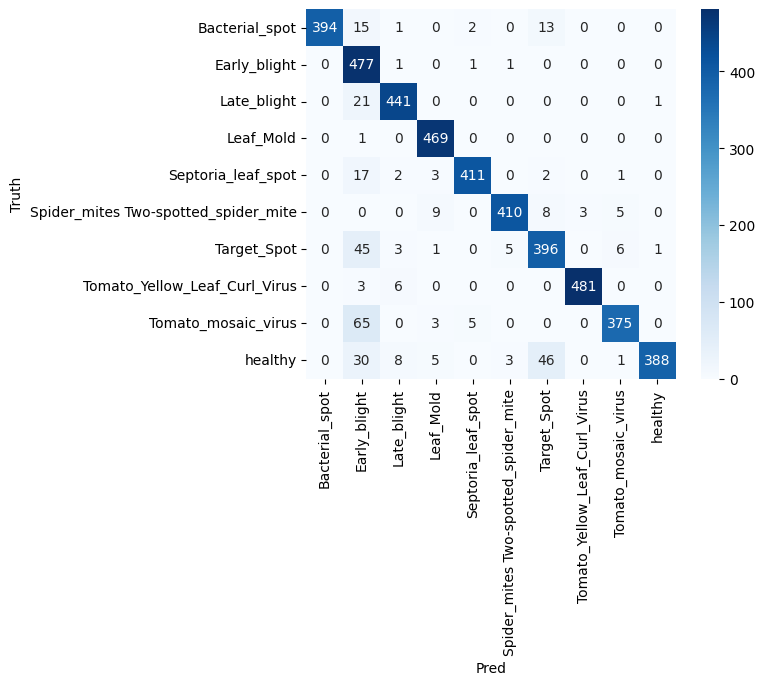

In [32]:
from sklearn.metrics import confusion_matrix

classes_list = list(sorted(model.class_to_idx.keys()))

matrix_confusion = confusion_matrix(true_list, pred, labels=classes_list)

classes_list = [i[9:] for i in classes_list]
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
#sns.heatmap(glue, annot=True)
ax.set(xlabel="Pred", ylabel="Truth")

In [33]:
import torchmetrics
pred_tensor, truth_tensor = torch.Tensor([model.class_to_idx[i] for i in pred]), torch.Tensor([model.class_to_idx[i] for i in true_list])

acc = torchmetrics.functional.accuracy(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
precision = torchmetrics.functional.precision(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
recall = torchmetrics.functional.recall(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
f1 = torchmetrics.functional.f1_score(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))

(acc, precision, recall, f1)

(tensor(0.9248), tensor(0.9386), tensor(0.9248), tensor(0.9276))

In [34]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["confusion_matrix"]["resnet34"] = np.array(matrix_confusion).tolist()
stats["metrics"]["accuracy"]["resnet34"] = float(acc)
stats["metrics"]["precision"]["resnet34"] = float(precision)
stats["metrics"]["recall"]["resnet34"] = float(recall)
stats["metrics"]["f1_score"]["resnet34"] = float(f1)

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

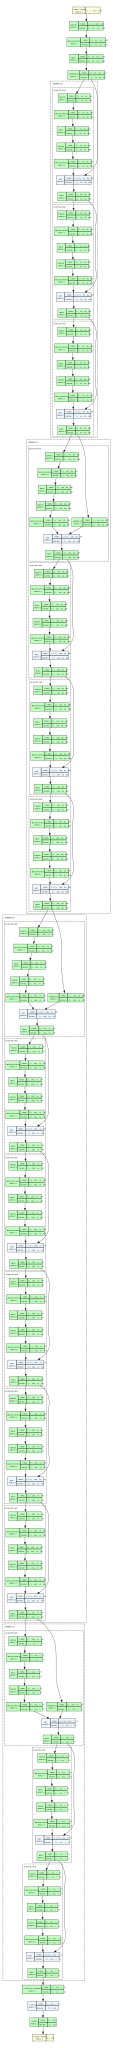

In [35]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device=device, expand_nested=True)
model_graph.visual_graph.node_attr["fontname"] = "Times-Roman"
model_graph.visual_graph